In [1]:
import csv
import datetime
import os, sys

import backtrader as bt
import empyrical as emp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ast import literal_eval

# Matplotlib init
plt.style.use("ggplot")
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.family"] = ["Heiti TC"]  # Or any other Chinese characters


In [2]:
class Logger:
    """将输出内容保存到本地文件"""

    def __init__(self, filename="trades.log"):
        self.terminal = sys.stdout
        self.log = open(filename, "w")

    def write(self, msg):
        self.terminal.write(msg)
        self.log.write(msg)

    def flush(self):
        pass


class MetaVar:

    valid_contracts = ["IF00", "IH00", "IC00"]

    def __init__(self, contract: str):
        # 合约设置
        if contract in self.valid_contracts:
            self.contract = contract
        else:
            print("Invalid contract name...")

        # 回测区间设置
        self.fromdate = datetime.datetime(2010, 4, 16)
        self.todate = datetime.datetime(2013, 12, 31)

        # 数据路径
        self.filepath = os.path.join(os.path.abspath("."), '5m_main_contracts', self.contract + ".csv")  # 5min data

        # 交易时间表
        # filepath = os.path.join(os.curdir, 'trading_time', self.contract + '_time.csv')  # 5min data
        time_filepath = os.path.join(os.path.abspath("."), "trading_time", self.contract + "_time.csv")  # 1min data
        self.time_df = pd.read_csv(time_filepath, index_col="date")


        self.startcash = 10_000_000

        # 交易手续费设置
        self.closeout_type = 1  # 1代表平今仓，0代表止盈止损平仓

        # 保证金设置
        if self.contract in ["IH00", "IC00"]:
            self.margin = 0.10
        elif self.contract == "IF00":
            self.margin = 0.12

        # 乘数设置
        if self.contract in ["IF00", "IH00"]:
            self.mult = 300.0
        elif self.contract == "IC00":
            self.mult = 200.0

        # 滑点设置

        # 印花税设置
        self.stamp_duty = 0.001



metavar = MetaVar("IF00")

In [3]:
class MainContract(bt.feeds.PandasData):
    params = (
        ("nullvalue", np.nan),
        ("fromdate", metavar.fromdate),
        ("todate", metavar.todate),
        ("datetime", None),  # index of the dataframe
        ("open", 0),
        ("high", 1),
        ("low", 2),
        ("close", 3),
        ("volume", 4),
        ("openinterest", -1),
    )


In [4]:
class FurCommInfo(bt.CommInfoBase):
    """定义期货的交易手续费和佣金"""

    params = (
        ("stocklike", False),
        ("commtype", bt.CommInfoBase.COMM_PERC),  # 按比例收取手续费
        ("percabs", True),  # 0.0002 = 0.2%
        ("commission", 3.45 / 10_000),  # 万分之3.45手续费
        ("mult", metavar.mult),  # 乘数300
        ("stamp_duty", metavar.stamp_duty),  # 印花税0.1%
        ('margin', metavar.margin),
        ("backtest_margin", 1.0),  # no leverage for now
    )

    def _getcommission(self, size, price, pseudoexec):
        """
        手续费=买卖手数*合约价格*手续费比例*合约乘数

        根据平仓类型`var.closeout_type`决定手续费比例
        - 平昨仓/止盈止损平仓: 0.23 / 10000
        - 平今仓: 3.45 / 10000
        """
        if metavar.closeout_type == 1:
            self.p.commission = 3.45 / 10000  # 平今仓
        else:
            self.p.commission = 0.23 / 10000  # 止盈止损平仓/开仓

        if size > 0:
            return abs(size) * price * self.p.commission * self.p.mult
        else:  # 卖出时考虑印花税
            return abs(size) * price * self.p.commission * self.p.mult

    def get_margin(self, price):
        """每笔交易保证金=合约价格*合约乘数*保证金比例"""
        return price * self.p.mult * self.p.backtest_margin 


In [5]:
class FurSizer(bt.Sizer):
    """基于真是波动幅度的头寸管理"""

    params = (
        ("theta", 0.02),  # 风险载荷
        ("adj_func", 1.0),  # 头寸调整函数
        ("fund", 100_000),  # 配置资金
        ("mult", 300),  # 合约乘数
        ("period", 11),  # 回测窗口
    )

    def _getsizing(self, comminfo, cash, data, isbuy):
        # price_change = abs(data.close[self.p.period] - data.close[0])
        # k_std = np.std(data.close.get(ago=0, size=self.p.period))  # 计算当前时间点前period天收盘价的标准差
        # size = self.p.adj_func * self.p.theta * self.p.fund // (k_std * price_change * self.p.mult) if price_change != 0 else 0

        tr = [
            max(data.high[0], data.close[-i]) - min(data.low[0], data.close[-i]) for i in range(1, self.p.period + 1)
        ]  # true range
        atr = sum(tr) / self.p.period  # 真实波动幅度
        size = self.p.adj_func * self.p.theta * self.p.fund // (atr * self.p.mult)

        return min(size, data.volume[0])  # 取计算所得值和当天成交量的最小值


In [6]:
class EnhancedRSI(bt.Strategy):
    params = (
        ("period", 11),  # 参考研报
        ("thold_l", 60),
        ("thold_s", 80),
        ('closeout_limit', 0.02),
        ('target_percent', 0.30),
    )

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime(0)
        print(f"{dt}: {txt}")

    def __init__(self):
        # 保存收盘价、开盘价、日期
        self.dataclose = self.datas[0].close
        self.dataopen = self.datas[0].open
        self.datadatetime = self.datas[0].datetime

        # 交易时间表

        filepath = os.path.join(os.curdir, "trading_time", "IF00_time.csv")
        self.time_df = pd.read_csv(filepath, index_col="date")

        # 设置指标
        self.rsi_s = bt.ind.RSI_SMA(self.datas[0], period=self.p.period, safediv=True)
        self.rsi_l = bt.ind.RSI_SMA(self.datas[1], period=self.p.period, safediv=True)

        # 处理等待中的order
        self.order = None
        self.ordermin = None

    def start(self):
        # Observers数据写入本地文件
        self.mystats = csv.writer(open("results.csv", "w"))
        self.mystats.writerow(
            [
                "datetime",
                "drawdown",
                "maxdrawdown",
                "timereturn",
                "value",
                "cash",
                "pnlplus",
                "pnlminus",
            ]
        )

    def next(self):
        today = bt.num2date(self.datadatetime[0]).date()
        trading_period = literal_eval(self.get_tradetime(today).values[0])
        open_time = trading_period[0]
        close_time = trading_period[-2]  # 使用收盘时间前一个bar作为平今仓信号
        now = bt.num2time(self.datadatetime[0]).isoformat()

        # 记录当天开盘价
        if now == open_time:
            self.open_price = self.dataopen[0]
        
        # 跳过当前交易的条件
        bypass_conds = [
            self.order,
            now == self.ordermin
        ]
        if any(bypass_conds):
            return

        # 交易信号
        # 做多信号：长期RSI > L & 短期RSI > S
        # 做空信号：长期RSI < 100-L & 短期RSI < 100-S
        long_sig = (self.rsi_l > self.params.thold_l) and (self.rsi_s > self.params.thold_s)
        short_sig = (self.rsi_l < 100 - self.params.thold_l) and (self.rsi_s < 100 - self.params.thold_s)

        # 策略逻辑
        metavar.closeout_type = 0
        if now == close_time and self.position:
            metavar.closeout_type = 1
            self.order = self.close()
            self.order.addinfo('CLOSE OUT AT THE END OF THE DAY')
        else:
            if not self.position:
                if long_sig:
                    self.order = self.order_target_percent(target=self.p.target_percent)
                elif short_sig:
                    self.order = self.order_target_percent(target=-self.p.target_percent)
            else:
                pct_change = self.dataclose[0] / self.open_price - 1  # 基于每日开盘价收益率
                cur_pos = self.broker.getposition(data=self.datas[0]).size
                long_close_sig = cur_pos > 0 and (pct_change < -self.p.close_limit)  # 持有多头且下跌超过阈值
                short_close_sig = cur_pos < 0 and (pct_change > self.p.close_limit)  # 持有空头且上涨超过阈值
                # 止损平仓
                if long_close_sig or short_close_sig:
                    self.order = self.order_target_percent(target=0)
                    self.order.addinfo('CLOSE OUT DUE TO STOPLIMIT')

        # Observers数据写入本地文件
        self.write_obs(-1)

    def stop(self):
        # Observers数据写入本地文件 - 最后一个bar
        self.write_obs(0)

    def notify_order(self, order):
        # 不处理已提交或已接受的订单
        if order.status in [order.Submitted, order.Accepted]:
            return

        # 处理已完成订单
        if order.status == order.Completed:
            margin_used = order.executed.price * order.executed.size * metavar.mult * metavar.margin
            self.ordermin = bt.num2time(self.datadatetime[0]).isoformat()

            if order.isbuy():
                self.log(f"LONG SIG DETECTED @ {order.created.price:.2f}")
                self.log(
                    f"BUY EXECUTED {order.executed.price:.2f}, SIZE {order.executed.size:.2f}, COST {order.executed.value:.2f}, COMMISSION {order.executed.comm:.2f}, MARGIN {margin_used:.2f}"
                )
            elif order.issell():
                self.log(f"SHORT SIG DETECTED @ {order.created.price:.2f}")
                self.log(
                    f"SELL EXECUTED {order.executed.price:.2f}, SIZE {order.executed.size:.2f}, COST {order.executed.value:.2f}, COMMISSION {order.executed.comm:.2f}, MARGIN {margin_used:.2f}"
                )
            
            if order.info:
                self.log(f"INFO {self.order.info['name']}")

        # 处理问题清单
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f"ORDER CANCELED/MARGIN/REJECTED **CODE**: {order.getstatusname()}")

        # Write down if no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f"OPERATION PROFIT {trade.pnl:.2f}, NET PROFIT {trade.pnlcomm:.2f}")

    def get_tradetime(self, today) -> list:
        """获取当日所有交易时间点"""
        return metavar.time_df.loc[today.isoformat()]

    def write_obs(self, t):
        self.mystats.writerow(
            [
                self.datadatetime.datetime(t).strftime("%Y-%m-%d %H:%M:%S"),
                f"{self.stats.drawdown.drawdown[0]:.2f}",
                f"{self.stats.drawdown.maxdrawdown[0]:.2f}",
                f"{self.stats.timereturn.timereturn[0]:.2f}",
                f"{self.stats.broker.value[0]:.2f}",
                f"{self.stats.broker.cash[0]:.2f}",
                f"{self.stats.trades.pnlplus[0]:.2f}",
                f"{self.stats.trades.pnlminus[0]:.2f}",
            ]
        )


In [7]:
def data_cleansing(filepath):
    """返回短期和长期价格序列"""
    # 保留字段OHLC, Volume
    cols = [
        "S_DQ_ADJOPEN",
        "S_DQ_ADJHIGH",
        "S_DQ_ADJLOW",
        "S_DQ_ADJCLOSE",
        "S_DQ_VOLUME",
    ]

    # Read .csv file and set TRADE_DT as index
    short_df = pd.read_csv(filepath, index_col="TRADE_DT")

    # 过滤字段
    short_df = short_df[cols]

    # Change TRADE_DT into datetime type
    short_df.index = pd.to_datetime(short_df.index)
    long_df = short_df.resample(rule="15min", origin="start").last().dropna()

    return short_df, long_df


In [8]:
# 保存回测交易单到本地
sys.stdout = Logger()

# For handling input data
short_df, long_df = data_cleansing(metavar.filepath)

# Initiate the strategy
cerebro = bt.Cerebro()
cerebro.addstrategy(EnhancedRSI)

# Load datas
data0 = MainContract(dataname=short_df)
data1 = MainContract(dataname=long_df)

# Add data feeds
cerebro.adddata(data0, name="short")
cerebro.adddata(data1, name="long")

# Add analyser
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="_TimeReturn")
cerebro.addanalyzer(bt.analyzers.TimeDrawDown, _name="_TimeDrawDown")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="_DrawDown")
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="_AnnualSharpe")
cerebro.addanalyzer(bt.analyzers.Returns, _name="_AnnualReturn")  # Annualisation

# Add observers
cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Broker setup
cerebro.broker.setcash(metavar.startcash)
# cerebro.addsizer(FurSizer)

# IF00 commission
comminfo = FurCommInfo()
cerebro.broker.addcommissioninfo(comminfo)

# Output log file
cerebro.addwriter(bt.WriterFile, out="log.csv", csv=True)

print(f"开始资金总额 {cerebro.broker.getvalue():.2f}")

results = cerebro.run()

# Results
strats = results[0]

print(f"结束资金总额 {cerebro.broker.getvalue():.2f}")

# cerebro.plot()


开始资金总额 10000000.00


AttributeError: 'Lines_LineSeries_LineIterator_DataAccessor_Strateg' object has no attribute 'open_price'

2010-04-16 15:10:00: SHORT SIG DETECTED @ 3419.00
2010-04-16 15:10:00: SELL EXECUTED 3419.00, SIZE -2.00, COST 2051400.00, COMMISSION 47.18, MARGIN -246168.00


# Visualisation

In [ ]:
rets = pd.Series(strats.analyzers._TimeReturn.get_analysis())  # Series of returns
cumrets = (rets + 1).cumprod()

maxrets = cumrets.cummax()
drawdown = (cumrets - maxrets) / maxrets


In [ ]:
results = pd.read_csv("results.csv", index_col="datetime")
results.index = pd.to_datetime(results.index)

results["cumrets"] = (results.timereturn + 1).cumprod()
results.drawdown = results.drawdown * -1

results.fillna(0, inplace=True)
results["pnl"] = results.pnlplus + results.pnlminus


## 累计收益率/最大回撤

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Ping Fang SC
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Ping Fang SC
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Ping Fang SC


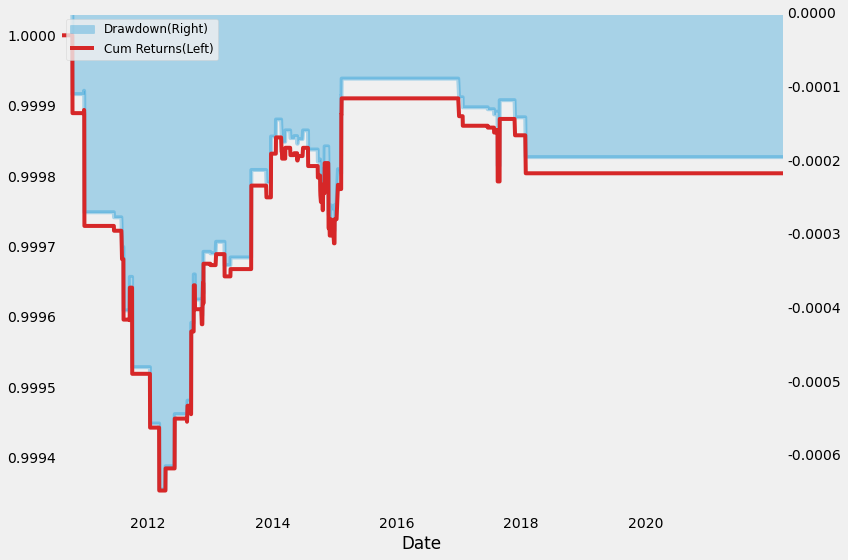

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))

x_names = pd.Series(rets.index.to_pydatetime()).dt.year.unique()

ax1 = drawdown.plot.area(alpha=0.3, grid=False, rot=0, label="Drawdown(Right)")
ax2 = ax1.twinx()
ax2 = cumrets.plot(grid=False, label="Cum Returns(Left)", color="tab:red")

ax1.yaxis.set_ticks_position("right")
ax2.yaxis.set_ticks_position("left")

ax1.set_xlabel("Date")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1 + h2, l1 + l2, fontsize=12, ncol=1, loc="upper left")

plt.margins(x=0)
fig.tight_layout()
plt.show()


## 累计收益率/标的价格走势

In [ ]:
contract_df = pd.read_csv("5m_main_contracts/IF00.csv", index_col="TRADE_DT")
contract_df.index = pd.to_datetime(contract_df.index)


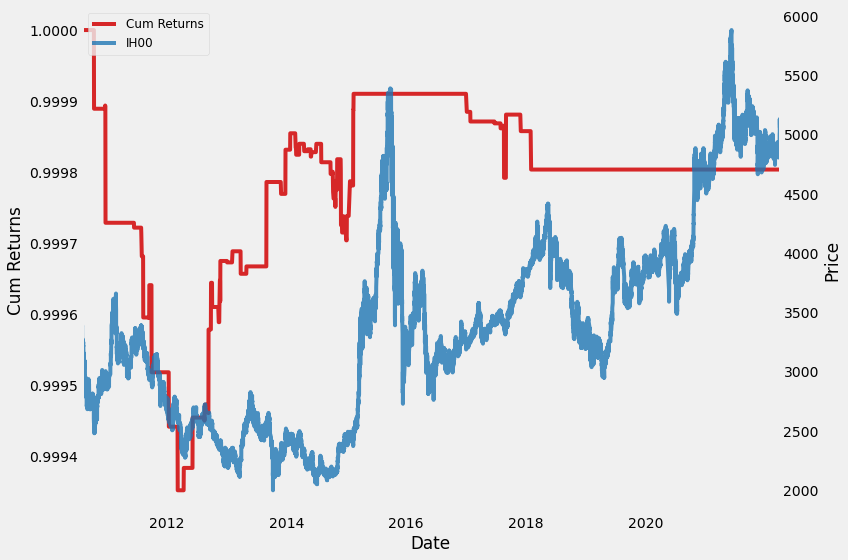

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.set_xlabel("Date")
ax1.set_ylabel("Cum Returns")
cumrets.plot(ax=ax1, grid=False, rot=0, label="Cum Returns", color="tab:red")
ax1.tick_params(axis="y")

ax2 = ax1.twinx()
ax2.set_ylabel("Price")
contract_df["S_DQ_CLOSE"].loc[:].plot(ax=ax2, color="tab:blue", grid=False, alpha=0.8, label="IH00")
ax2.tick_params(axis="y")


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1 + h2, l1 + l2, fontsize=12, ncol=1, loc="upper left")

plt.margins(x=0)
fig.tight_layout()
plt.show()


## 净值曲线

In [ ]:
results.fillna(0, inplace=True)
results["pnl"] = results.pnlplus + results.pnlminus


In [ ]:
startcash = 10_000_000
results["pnl"][0] = results["pnl"][0] + startcash
results["net_profit"] = results["pnl"].cumsum()


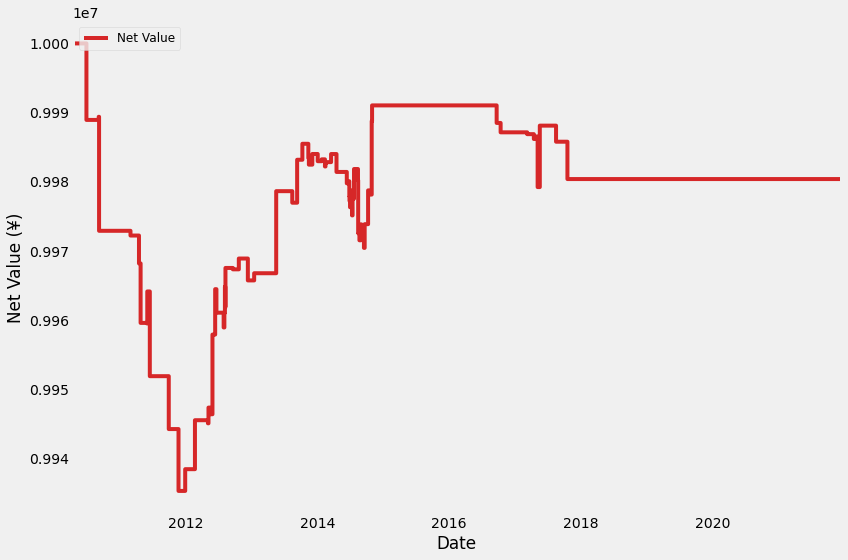

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel("Date")
ax.set_ylabel("Net Value (¥)")
ax = plt.plot(results.net_profit, label="Net Value", color="tab:red")


plt.margins(x=0)
plt.grid(False)
plt.legend(loc="upper left", fontsize=12)
fig.tight_layout()
plt.show()


In [ ]:
short_df


,S_DQ_ADJOPEN,S_DQ_ADJHIGH,S_DQ_ADJLOW,S_DQ_ADJCLOSE,S_DQ_VOLUME
TRADE_DT,,,,,
2010-04-16 09:20:00,3450.00,3488.00,3448.00,3454.00,1525
2010-04-16 09:25:00,3454.00,3460.00,3450.20,3456.00,816
2010-04-16 09:30:00,3456.00,3457.00,3438.00,3447.00,1308
2010-04-16 09:35:00,3446.80,3458.20,3443.00,3451.60,1298
2010-04-16 09:40:00,3451.00,3454.00,3443.80,3446.60,1050
...,...,...,...,...,...
2021-12-10 14:40:00,7213.38,7222.21,7212.53,7220.79,1037
2021-12-10 14:45:00,7221.07,7221.07,7214.52,7215.37,852
2021-12-10 14:50:00,7216.51,7221.64,7215.66,7219.36,1278


In [ ]:
cumrets[-1]


0.9998038815410495

## 交易明细

In [ ]:
annual_rets = pd.Series(strats.analyzers._AnnualReturn.get_analysis())
annual_sharpe = strats.analyzers._AnnualSharpe.get_analysis()
dd = strats.analyzers._TimeDrawDown.get_analysis()
day_ret_max = pd.Series(strats.analyzers._TimeReturn.get_analysis()).describe()["max"]
day_ret_min = pd.Series(strats.analyzers._TimeReturn.get_analysis()).describe()["min"]


print(f"年化夏普比率: {annual_sharpe['sharperatio']:.2f}")
print(f"最大回撤: {dd['maxdrawdown'] * -1:.2%}")
print(f"累计收益率: {cumrets[-1]:.2%}")
print(f"年化收益率: {annual_rets['rnorm100']:.2f}")
print(f"收益回撤比: {annual_rets['rnorm'] / dd['maxdrawdown']:.2f}")
print(f"单日最大收益: {day_ret_max:.2%}")
print(f"单日最大亏损: {day_ret_min:.2%}")


年化夏普比率: -62.51
最大回撤: -6.47%
累计收益率: 99.98%
年化收益率: -0.09
收益回撤比: -0.01
单日最大收益: 0.01%
单日最大亏损: -0.02%


In [ ]:
sharpe_ratio = (annual_rets["rnorm"] - 0.01) / rets.std()
sharpe_ratio


-1389.222817927117

In [ ]:
rets.std()


7.87587825216129e-06